In [2]:
import rioxarray
import geopandas
import os
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle

In [3]:
out_dir = "data/_grace_tiff"
os.makedirs(out_dir, exist_ok=True)
geodf = geopandas.read_file("data/aoi.geojson")
nc = rioxarray.open_rasterio("data/GRCTellus.JPL.200204_202202.GLO.RL06M.MSCNv02CRI.nc", decode_times=False)[0]
grace_start_date = datetime.datetime(2002, 1, 1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dat

In [4]:
nc

<xarray.Dataset>
Dimensions:        (time: 206, x: 720, y: 360)
Coordinates:
  * time           (time) float64 106.5 129.5 227.5 ... 7.32e+03 7.35e+03
  * x              (x) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * y              (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    WGS84          int64 0
Data variables:
    lwe_thickness  (time, y, x) float64 ...
    uncertainty    (time, y, x) float64 ...
Attributes: (12/53)
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_institution:           NASA/JPL
    creator_name:                  David Wiese
    creator_type:                  group
    ...                            ...
    time_coverage_start:           2002-04-16T00:00:00Z
    time_epoch:                    2002-01-01T00:00:00Z
    time_mean_removed:             2004.000 to 2009.999
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...

In [5]:
nc = nc.rio.write_crs("EPSG:4326")
print("Extracting tifs...")
df = pd.DataFrame(columns = ["date", "value", "mask"])
dates = []
for lwe in tqdm(nc["lwe_thickness"]):
    lwe = lwe.rio.clip(geodf.geometry.values, geodf.crs, all_touched=True)
    lwe = lwe.rio.write_crs("EPSG:4326")
    new_width = 13
    new_height = 8

    lwe_upsampled = lwe.rio.reproject(
        lwe.rio.crs,
        shape=(new_height, new_width),
    )
    lwe_datetime = grace_start_date + datetime.timedelta(days=int(lwe.time.values))
    lwe_upsampled.values[lwe_upsampled.values < -99990] = np.nan
    mean = lwe_upsampled.mean(skipna=True)
    masked = lwe_upsampled.to_masked_array()
    dates.append(lwe_datetime.strftime('%Y-%m-%d'))
    df = df.append({'date': lwe_datetime.strftime('%Y-%m-%d'), 'value': masked.data, 'mask': masked.mask}, ignore_index=True)

Extracting tifs...


  0%|          | 0/206 [00:00<?, ?it/s]/var/folders/4p/ctysll0s0551b50jtg8djbs40000gp/T/ipykernel_37891/3892097984.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'date': lwe_datetime.strftime('%Y-%m-%d'), 'value': masked.data, 'mask': masked.mask}, ignore_index=True)
  0%|          | 1/206 [00:00<00:33,  6.11it/s]/var/folders/4p/ctysll0s0551b50jtg8djbs40000gp/T/ipykernel_37891/3892097984.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'date': lwe_datetime.strftime('%Y-%m-%d'), 'value': masked.data, 'mask': masked.mask}, ignore_index=True)
  1%|          | 2/206 [00:00<00:29,  6.93it/s]/var/folders/4p/ctysll0s0551b50jtg8djbs40000gp/T/ipykernel_37891/3892097984.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

In [6]:
with open('data/grace_dates.pickle', 'wb') as f:
    pickle.dump(dates, f)

In [8]:
df.loc[df["date"] == "2012-01-01"]
df.iloc[111]["date"] = "2011-12-01"
df.iloc[144]["date"] = "2015-05-01"
df.to_pickle("data/grace_df.pickle")

In [18]:
df.iloc[0]

date                                            2002-04-01
value    [[nan, nan, nan, 6.828635107805798, 6.82863510...
mask     [[True, True, True, False, False, False, False...
Name: 0, dtype: object

In [10]:
for lwe in tqdm(nc["lwe_thickness"]):
    lwe = lwe.rio.clip(geodf.geometry.values, geodf.crs, all_touched=True)
    lwe = lwe.rio.write_crs("EPSG:4326")
    break

  0%|          | 0/206 [00:00<?, ?it/s]


<AxesSubplot:title={'center':'time = 106.5 [days since 2002-01-01T00:00:00Z],...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

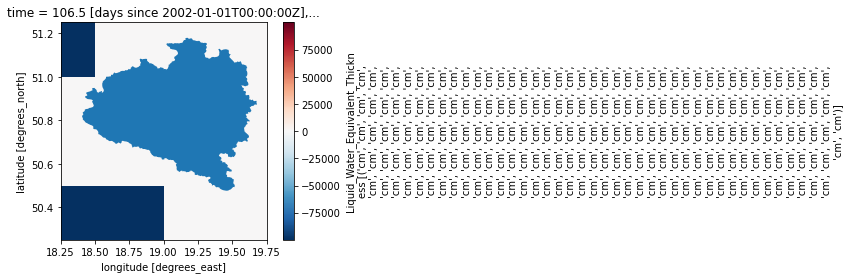

In [17]:
ax = plt.gca()
lwe.plot.pcolormesh(ax = ax, 
geodf.plot(ax = ax)